**Preamble**

This is a **group** assignment. Please indicate the names of all group members below. 
Each group is to comprise *four* to *five* members.

If the group obtains a solution through research (e.g., on the web), then the group is to acknowledge the source, but *write up the solution in their OWN WORDS*.

## Traveling Salesperson Problem (TSP)

If you need help on using iPython notebooks, click <a href='#help'>here</a>. 

Assignment objectives:

i. Using PuLP and techniques from Dantzig, Fulkerson, Johnson (refer to lecture notes),
implement a routine to compute a lower bound for a TSP instance.

ii. Using the implemented routine, obtain tight estimates on two TSP instances.

**(a) (5 marks)** Implement a routine in PuLP that computes a lower bound for a TSP instance.

Specifically, your routine should take as 

**inputs:**

- a list of `cities`,
- a distance dictionary `dist`,
- a list of subtours `S`,

and **output** a number $L_1$ such that the shortest TSP tour for `cities`, `dist` is at least $L_1$. 

<span style='color:blue'>For the example below, your routine should compute $L_1$ to be $32$.</span>

In [37]:
# Example 2 in Dantzig, Fulkerson, Johnson
# See example in class notes

cities = [1,2,3,4,5]
dist = {
               (1,2): 5,  (1,3): 6,  (1,4): 10, (1,5):8,
    (2,1): 5,             (2,3): 5,  (2,4): 12, (2,5):12,
    (3,1): 6,  (3,2): 5,             (3,4): 8,  (3,5):10,
    (4,1): 10, (4,2): 12, (4,3): 8,             (4,5):6,
    (5,1): 8,  (5,2): 12, (5,3): 10, (5,4):6,   
}

S = [
    [4,5]
]

In [50]:
from pulp import *

def AddSubtourConstraints(prob, subtours, list_cities, X_ijs):
    for subtour in subtours:
        list_non_subtours = list(set(list_cities) - set(subtour))
        prob += (lpSum([X_ijs[(non_subtour_city, i)]
                        for non_subtour_city in list_non_subtours 
                        for i in subtour
                        if (non_subtour_city, i) in X_ijs]) >= 2)
    return prob

def GetFullEdgesAndFractionalEdges(list_cities, X_ijs):
    edges = []
    fedges = []
    for i in list_cities:
        for j in list_cities:
            if((i,j) in X_ijs) and (X_ijs[(i,j)].varValue > 0):
                if X_ijs[(i,j)].varValue == 1:
                    edges.append((i,j))
                else:
                    fedges.append((i,j))
    return edges, fedges


# Helper functions
def Identify_One_Island(subtour_cities, X_ij_s):
    
    '''
    Helper function:
        Generate one subtour and return it,
        it doesn't matter starting from which city
    '''
    
    ret_tour = list()
    subtour_cities_copy = subtour_cities.copy()
    
    start_city = subtour_cities[0]
    ret_tour.append(subtour_cities_copy.pop(subtour_cities_copy.index(start_city)))
    
    found_subtour = False
    
    while len(subtour_cities_copy) > 0 and not found_subtour:
        for i in subtour_cities_copy:
            if (X_ij_s[(start_city,i)].varValue > 0) or (X_ij_s[(i, start_city)].varValue > 0):
                ret_tour.append(subtour_cities_copy.pop(subtour_cities_copy.index(i)))
                start_city = i
                break
            else:
                # reaches end, but couldn't find a link, identified end of a subtour
                if i == subtour_cities_copy[-1]:
                    found_subtour = True
                    
    return ret_tour
            
def Identify_All_Islands(list_cities, X_ij_s):
    
    '''
    Helper function:
        Based on decision variable's value, 
        identify the list of subtours INCLUDING the main tour
    '''
    
    list_cities_copy = list_cities.copy()
    
    # container to hold list of subtours
    ret_tours = list()
    
    while len(list_cities_copy) > 0:
        ret_tour = Identify_One_Island(list_cities_copy, X_ij_s)
        ret_tours.append(ret_tour)
        list_cities_copy = list(set(list_cities_copy) - set(ret_tour))
    return ret_tours

def Print_Cities_With_Linkage(list_cities, X_ij_s):
    for i in list_cities:
        for j in list_cities:
            if ((i,j) in X_ij_s) and (X_ij_s[(i,j)].varValue > 0):
                print(i, " to ", j, " with value of ", X_ij_s[(i,j)].varValue)
    print('\n')
    

In [39]:
############################
# Part (a) Required Routine
############################

def Tsp_L1(list_cities, dict_distances, list_subtour=[]):
    
    '''
    This function takes the following params
        @list_cities: the collect of cities
        @ict_dist: the collection inter-city distances
        @ist_subtour: the list of subtour, each subtour is also a list of cities
    '''
    # problem
    tspProb = LpProblem("TSP", LpMinimize)

    # decision variables
    X_ij_s = LpVariable.dicts('DecisionVariables', dict_distances, 0, 1, cat=LpContinuous)  # from 0 to 1 of Continous

    # cost 
    C_ij_s = lpSum([X_ij_s[(i,j)] * dict_distances[(i,j)]] for (i,j) in dict_distances)

    # update the prob
    tspProb  += C_ij_s

    # add the constraints
    for i in list_cities:
                     # all inbound to city i should sum up to 1
        tspProb += ( lpSum([ X_ij_s[(from_city, i)] 
                            for from_city in list_cities 
                            if (from_city, i) in X_ij_s]) 
                     # all outbound from city i should sum up to 1
                   + lpSum([ X_ij_s[(i, to_city)] 
                           for to_city in list_cities 
                           if (i, to_city) in X_ij_s]) 
                     # hence 2 here
                 == 2)
        
       
    #Dummy_U_s = LpVariable.dicts('Dummy_U_s', list_cities, 0, len(list_cities)-1, LpInteger)
    #N=len(list_cities)
    #print(N)
    #for i in list_cities:
    #    for j in list_cities:
    #        if i != j and (i != 1 and j!= 1) and (i,j) in X_ij_s:
                #print(i, j)
                #tspProb += Dummy_U_s[i] - Dummy_U_s[j] <= (N)*(1-X_ij_s[(i,j)]) - 1
    #            tspProb += lpSum([Dummy_U_s[i] - Dummy_U_s[j] + N*X_ij_s[i,j]]) <= N-1
    
    
    for subtour in list_subtour:
        list_non_subtour = list(set(list_cities) - set(subtour))
        if (len(list_non_subtour) == 0):
            break
        
        # for each subtour make sure the numbers of links to each city in the subtour >=1
        tspProb += (lpSum([ X_ij_s[(non_subtour_city, i)] 
                            for i in subtour 
                            for non_subtour_city in list_non_subtour 
                            if (non_subtour_city, i) in X_ij_s]) 
                        >= 2)

    for i in list_cities:
        for j in list_cities:
            if i != j:
                tspProb += X_ij_s[(i,j)] + X_ij_s[(j,i)] <= 1
                
    tspProb.solve()
    #print(tspProb)
    print(LpStatus[tspProb.status])
    print("Minimum Cost: {}".format(value(tspProb.objective)))
                    
    return tspProb,X_ij_s

# try solving it first by ignoring subtour
prob,X_ij_s = Tsp_L1(cities, dist) # this is to verify the subtour is indeed [4,5]
Print_Cities_With_Linkage(cities, X_ij_s)
 
subtourr = Identify_All_Islands(cities, X_ij_s)
print("subtr: " ,subtourr)

print('\n')

# including subtours, and verify if it's 32
prob1, X_ij_s1 = Tsp_L1(cities, dist, S)
Print_Cities_With_Linkage(cities, X_ij_s1)
print(Identify_One_Island(cities, X_ij_s1))

Optimal
Minimum Cost: 32.0
1  to  5  with value of  1.0
2  to  1  with value of  1.0
2  to  3  with value of  1.0
4  to  3  with value of  1.0
4  to  5  with value of  1.0


subtr:  [[1, 2, 3, 4, 5]]


Optimal
Minimum Cost: 32.0
1  to  2  with value of  1.0
1  to  5  with value of  1.0
2  to  3  with value of  1.0
3  to  4  with value of  1.0
4  to  5  with value of  1.0


[1, 2, 3, 4, 5]


----

**(b) (10 marks)** 

For each of the two given instances, let $L^*$ be the length of a shortest TSP tour.

Using the routine in (a) (and some appropriate choices of `S`), compute a lower bound $L_1$.
From the solution in (a), guess a 'short' TSP tour and hence, obtain an upper bound $L_2$.
Therefore, 
$$L_1\le L^*\le L_2.$$

The marks to be awarded will depend the quality of your estimates, or equivalently, the ratio $L_2/L_1$. The specific mark allocation for each TSP instance is as follows.

|  &nbsp; &nbsp; &nbsp; &nbsp; Ratio $R=L_2/L_1$ &nbsp;  &nbsp; &nbsp; &nbsp;   |  Mark(s)    |
|:--------------------:|:-----------:| 
| $R>1.5$              | 0|
| $1.1 < R \le 1.5$    | 2 |
| $1.05 < R \le 1.1$ | 3 |
| $1.01 < R \le 1.05$ | 4 |
| $R \le 1.01$ | 5 |



## TSP B1

In [40]:
# Question B1

from TSP_B1 import *
import pulp

print("number of cities : {}".format(len(cities_B1)))

cities_B1_list = list(cities_B1)

subbb = []

b1_prob1, B1_X_ij_s = Tsp_L1(cities_B1_list, dist_B1)
Print_Cities_With_Linkage(cities_B1_list, B1_X_ij_s)
all_subtours = Identify_All_Islands(cities_B1_list, B1_X_ij_s)
print(len(all_subtours), " subtours: ", all_subtours)

number of cities : 45
Optimal
Minimum Cost: 1145.0
2  to  1  with value of  1.0
3  to  4  with value of  1.0
4  to  2  with value of  1.0
5  to  19  with value of  1.0
6  to  1  with value of  1.0
6  to  7  with value of  1.0
8  to  7  with value of  1.0
8  to  9  with value of  1.0
9  to  10  with value of  1.0
11  to  15  with value of  1.0
12  to  21  with value of  1.0
15  to  10  with value of  1.0
16  to  20  with value of  1.0
16  to  21  with value of  1.0
17  to  32  with value of  1.0
18  to  31  with value of  1.0
19  to  3  with value of  1.0
22  to  12  with value of  1.0
22  to  13  with value of  1.0
23  to  13  with value of  1.0
24  to  23  with value of  1.0
24  to  31  with value of  1.0
25  to  41  with value of  1.0
26  to  29  with value of  1.0
26  to  30  with value of  1.0
28  to  27  with value of  1.0
28  to  40  with value of  1.0
29  to  27  with value of  0.5
30  to  14  with value of  1.0
32  to  18  with value of  1.0
33  to  17  with value of  1.0
33  t

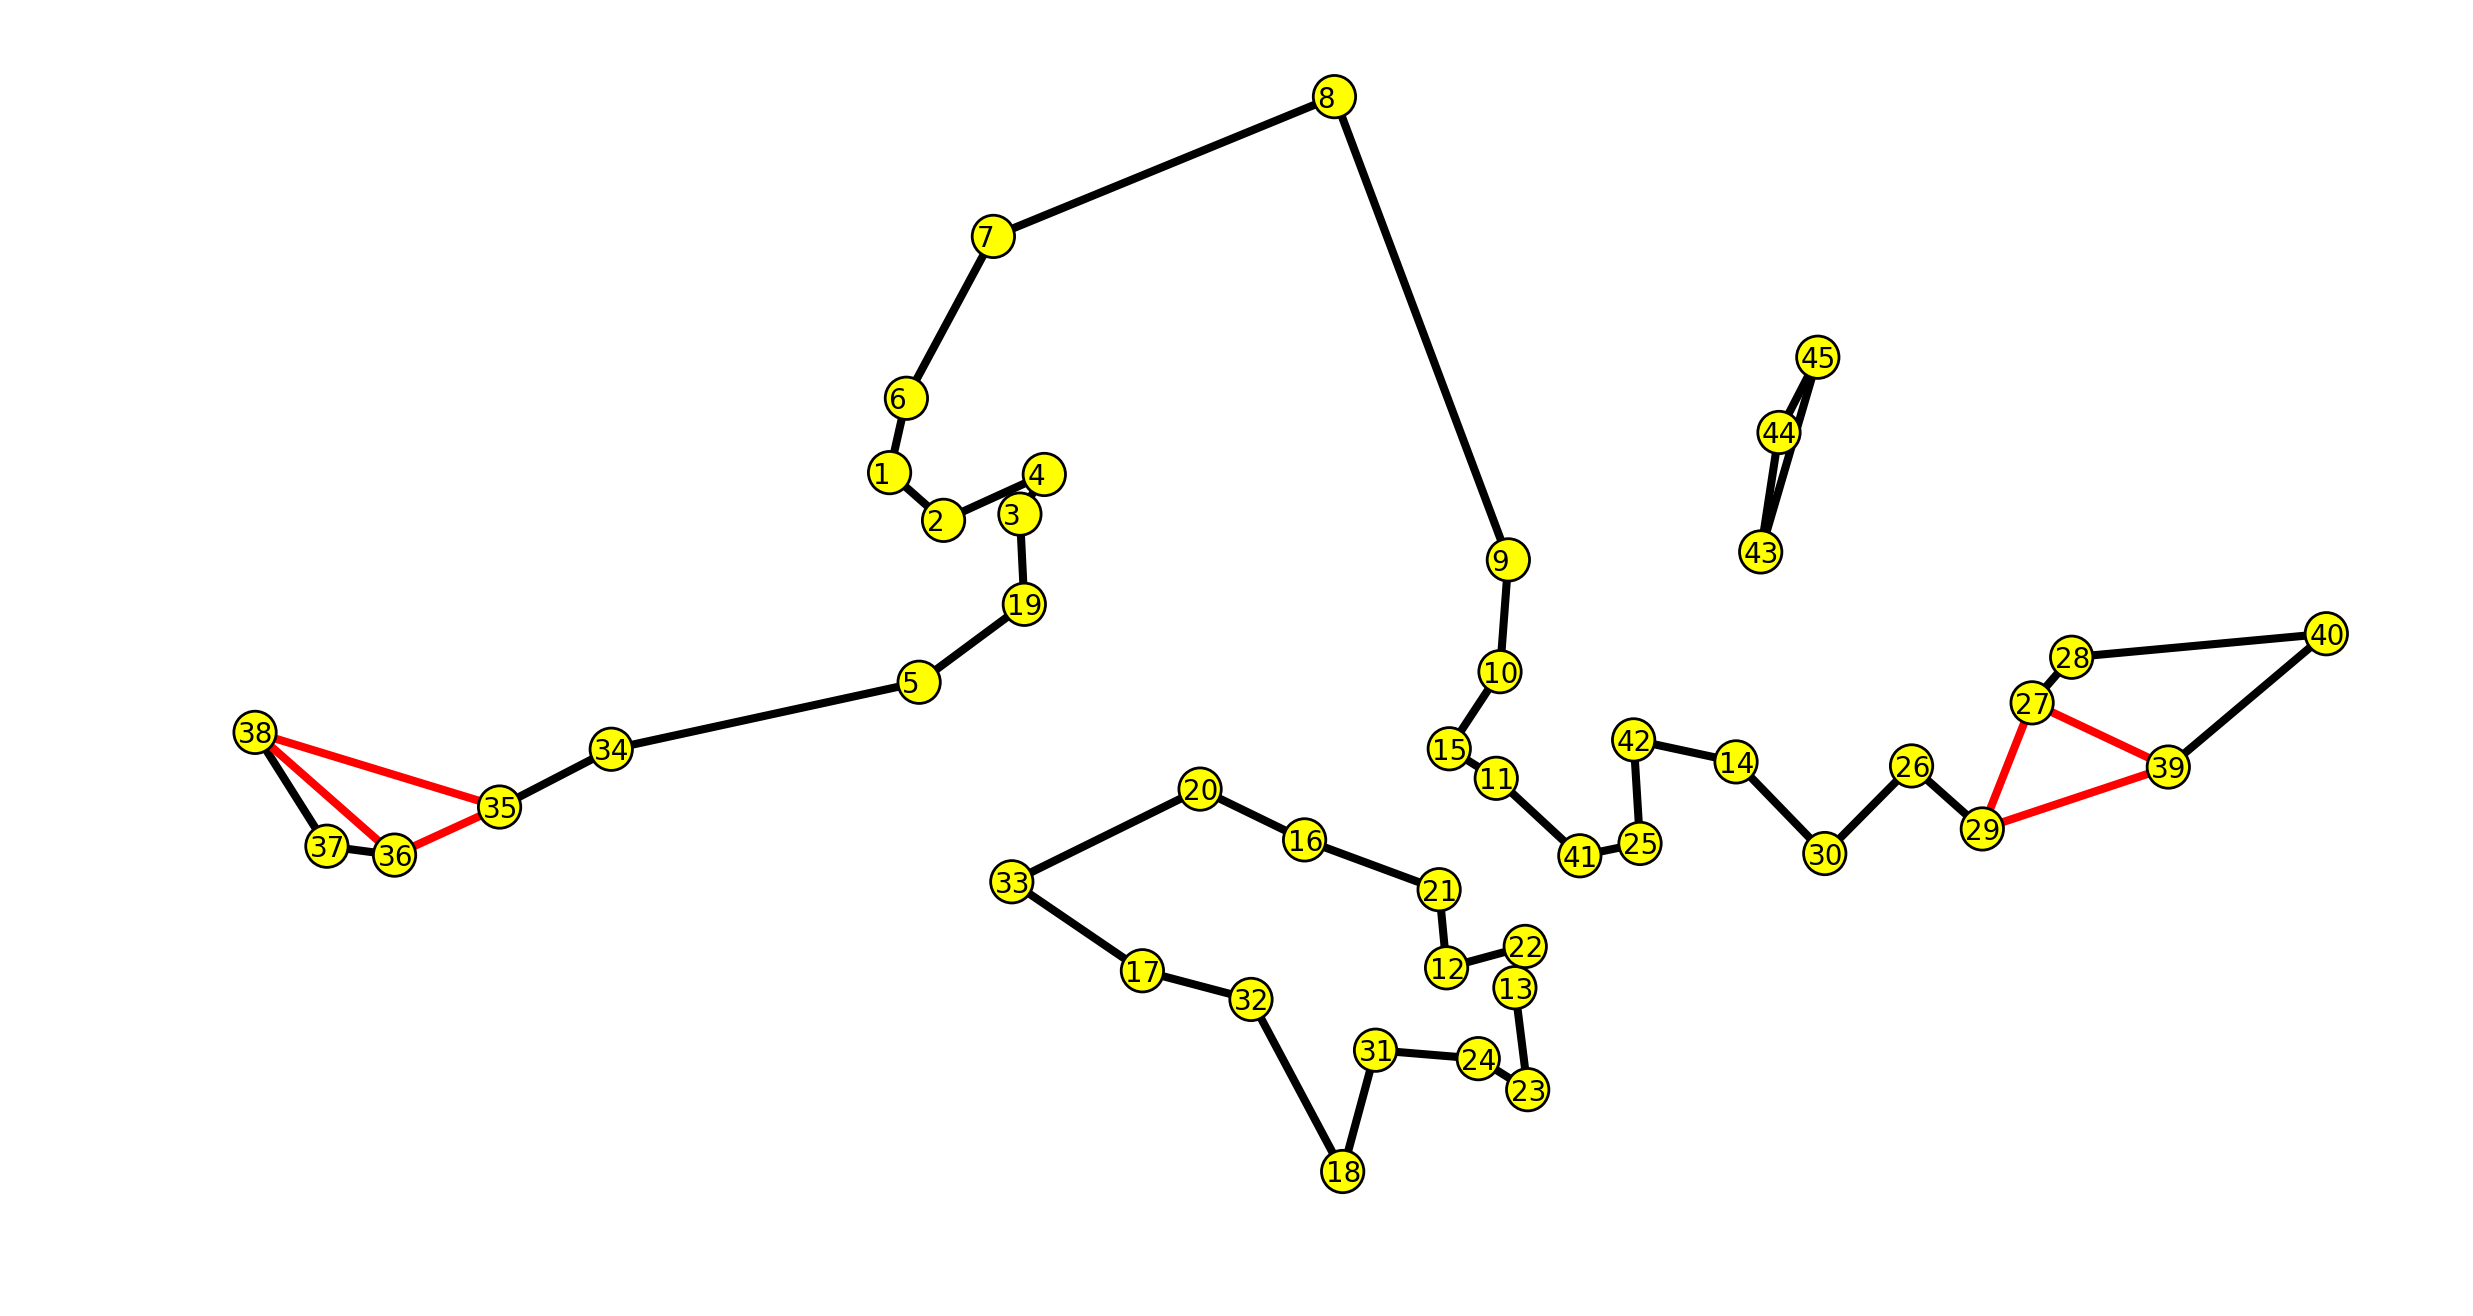

In [53]:
ee, ff = GetFullEdgesAndFractionalEdges(cities_B1_list, B1_X_ij_s)
LL = frac_TSP_plot(ee,ff,cities_B1_list,posn_B1,dist_B1)


In [54]:
b1_prob1_copy = b1_prob1.copy()

In [85]:
AddSubtourConstraints(b1_prob1, [[14,26,29,30]], cities_B1_list, B1_X_ij_s)

TSP:
MINIMIZE
121*DecisionVariables_(1,_10) + 128*DecisionVariables_(1,_11) + 140*DecisionVariables_(1,_12) + 152*DecisionVariables_(1,_13) + 168*DecisionVariables_(1,_14) + 117*DecisionVariables_(1,_15) + 104*DecisionVariables_(1,_16) + 105*DecisionVariables_(1,_17) + 157*DecisionVariables_(1,_18) + 35*DecisionVariables_(1,_19) + 13*DecisionVariables_(1,_2) + 83*DecisionVariables_(1,_20) + 130*DecisionVariables_(1,_21) + 149*DecisionVariables_(1,_22) + 167*DecisionVariables_(1,_23) + 156*DecisionVariables_(1,_24) + 158*DecisionVariables_(1,_25) + 200*DecisionVariables_(1,_26) + 220*DecisionVariables_(1,_27) + 225*DecisionVariables_(1,_28) + 217*DecisionVariables_(1,_29) + 25*DecisionVariables_(1,_3) + 190*DecisionVariables_(1,_30) + 142*DecisionVariables_(1,_31) + 120*DecisionVariables_(1,_32) + 80*DecisionVariables_(1,_33) + 74*DecisionVariables_(1,_34) + 97*DecisionVariables_(1,_35) + 118*DecisionVariables_(1,_36) + 127*DecisionVariables_(1,_37) + 129*DecisionVariables_(1,_38) + 247

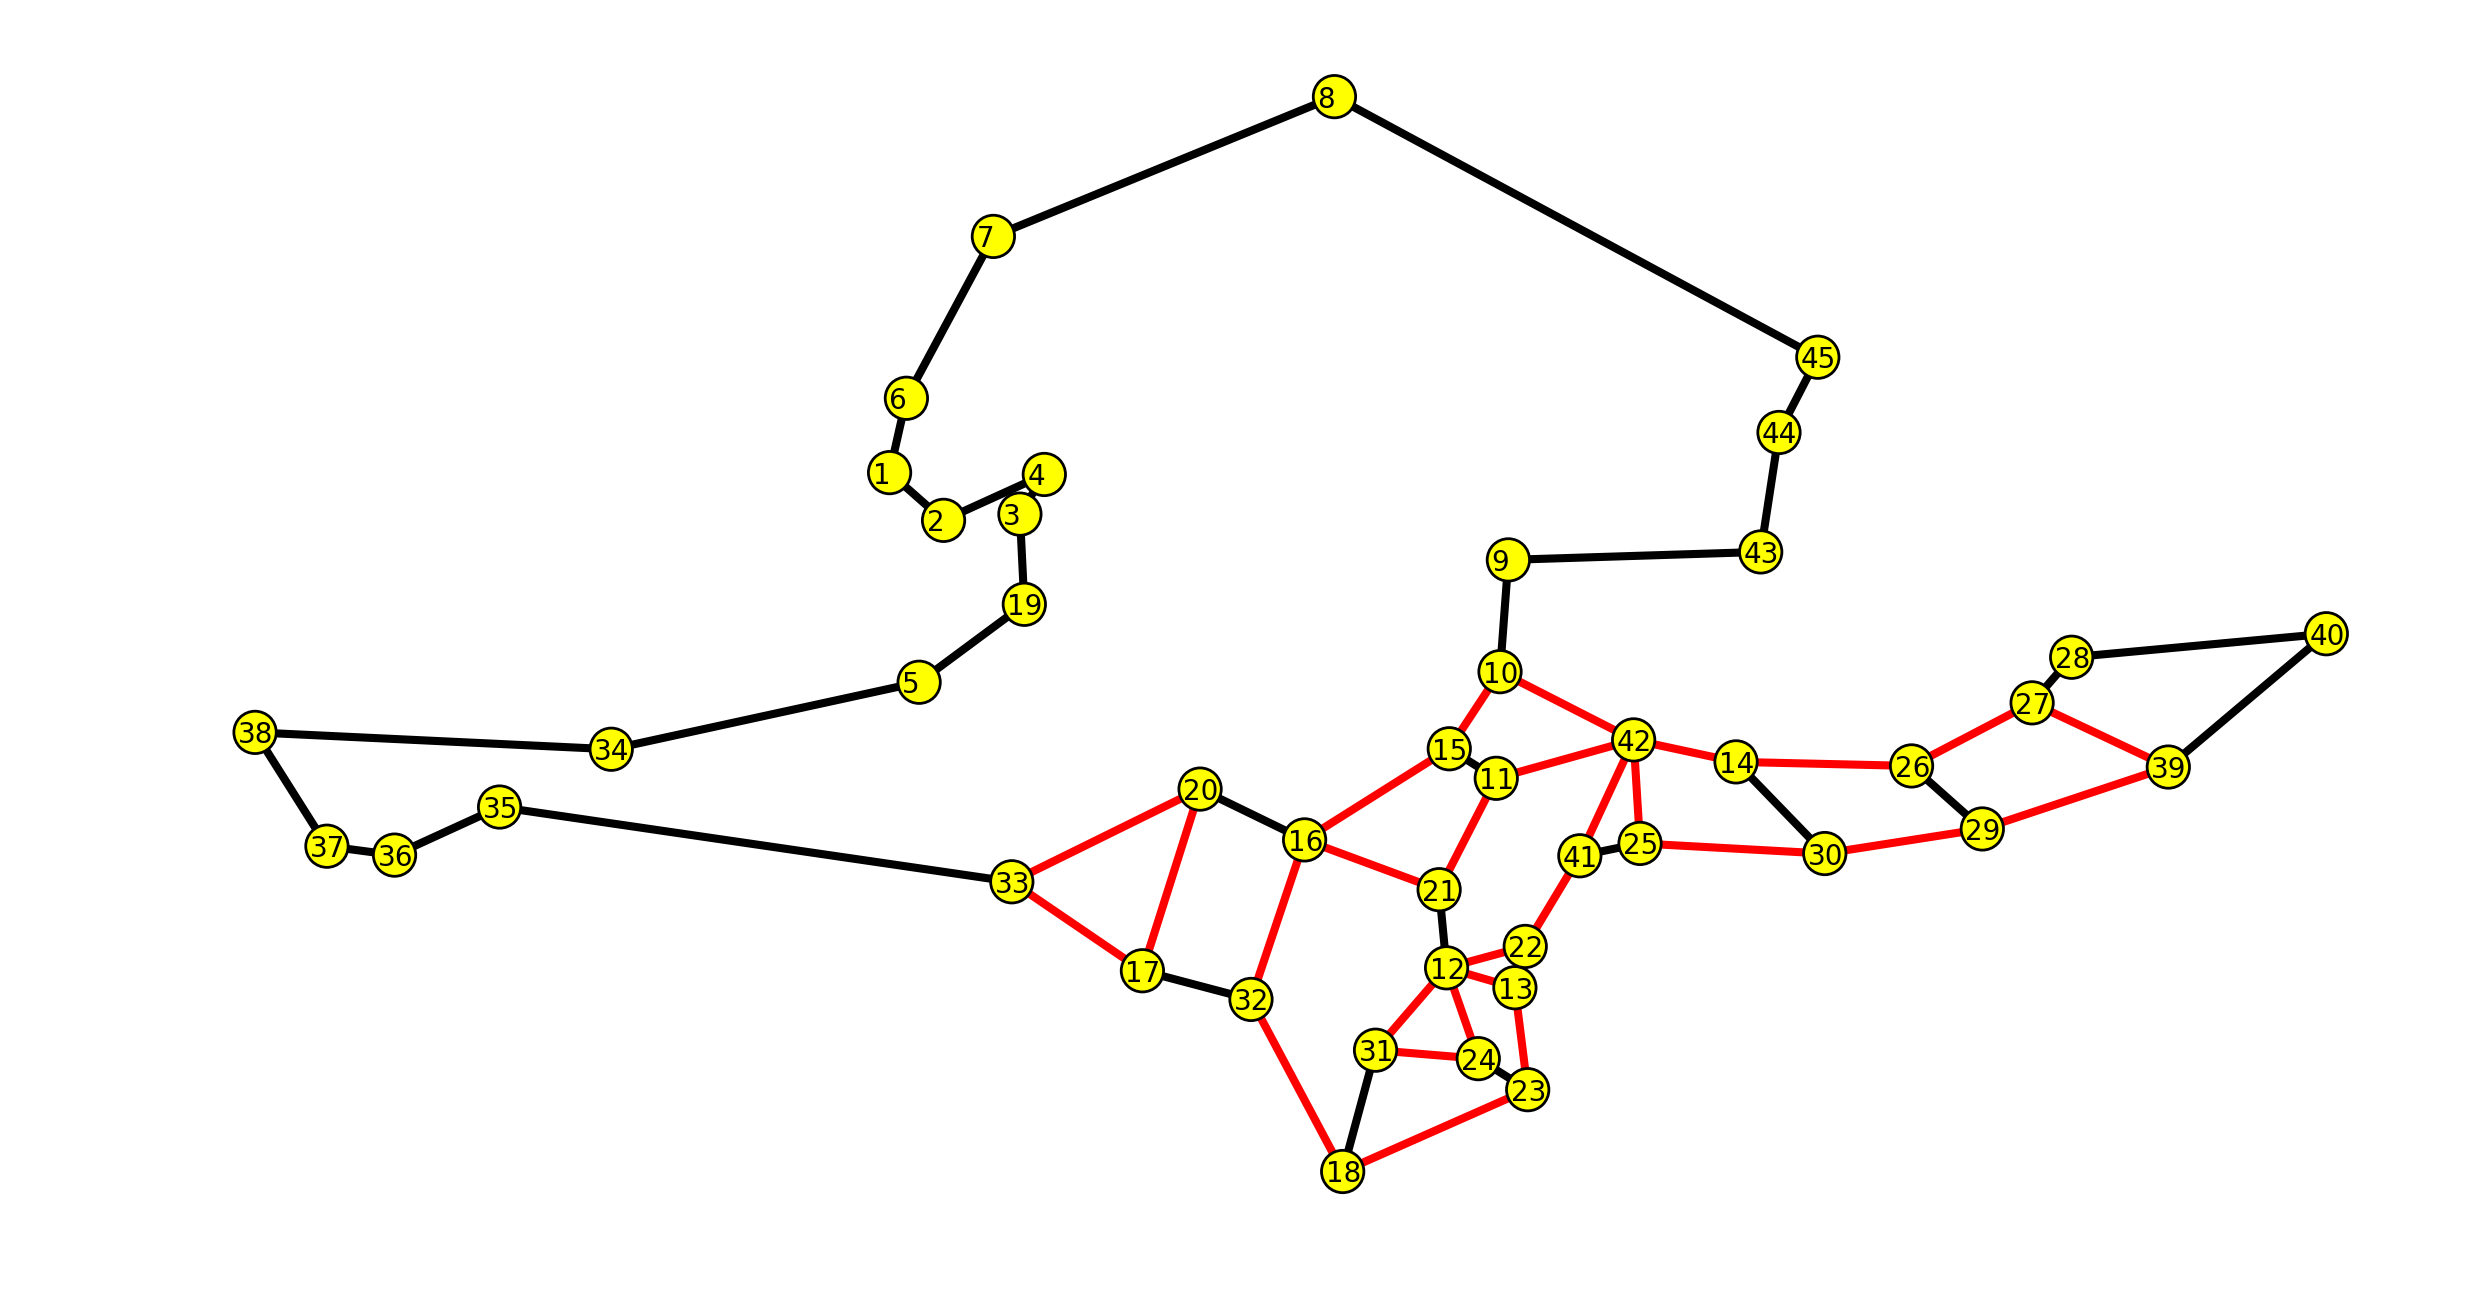

Optimal
Minimum Cost: 1289.3333333500002


In [86]:
b1_prob1.solve()
ee, ff = GetFullEdgesAndFractionalEdges(cities_B1_list, B1_X_ij_s)
LL = frac_TSP_plot(ee,ff,cities_B1_list,posn_B1,dist_B1)
print(LpStatus[b1_prob1.status])
print("Minimum Cost: {}".format(value(b1_prob1.objective)))

In [30]:
# Question B1

from TSP_B1 import *
import pulp

#print("number of cities : {}".format(len(cities_B1)))

#cities_B1_list = list(cities_B1)

#subbb = []

b1_prob1, B1_X_ij_s = Tsp_L1(cities_B1_list, dist_B1, all_subtours)
Print_Cities_With_Linkage(cities_B1_list, B1_X_ij_s)
all_subtours = Identify_All_Islands(cities_B1_list, B1_X_ij_s)
print(len(all_subtours), " subtours: ", all_subtours)

Optimal
Minimum Cost: 1186.5000015740004
1  to  2  with value of  1.0
2  to  6  with value of  0.022222222
3  to  4  with value of  0.97777778
3  to  19  with value of  0.97777778
4  to  3  with value of  0.022222222
4  to  7  with value of  0.97777778
5  to  19  with value of  0.97777778
5  to  33  with value of  1.0
6  to  1  with value of  1.0
6  to  2  with value of  0.97777778
7  to  4  with value of  0.022222222
7  to  8  with value of  0.022222222
8  to  7  with value of  0.97777778
8  to  45  with value of  1.0
9  to  10  with value of  0.022222222
9  to  43  with value of  1.0
10  to  9  with value of  0.97777778
10  to  15  with value of  1.0
11  to  15  with value of  1.0
11  to  21  with value of  0.97777778
12  to  13  with value of  0.97777778
12  to  21  with value of  0.022222222
13  to  12  with value of  0.022222222
13  to  22  with value of  0.022222222
14  to  30  with value of  0.022222222
14  to  42  with value of  0.97777778
16  to  20  with value of  0.97777778


In [17]:
# Question B2

from TSP_B2 import *
import pulp

print("number of cities : {}".format(len(cities_B2)))

cities_B2_list = list(cities_B2)

subbb = []

b2_prob1, B2_X_ij_s = Tsp_L1(cities_B2_list, dist_B2)
Print_Cities_With_Linkage(cities_B2_list, B2_X_ij_s)
all_subtours = Identify_All_Islands(cities_B2_list, B2_X_ij_s)
print(len(all_subtours), " subtours: ", all_subtours)

number of cities : 45
Optimal
Minimum Cost: 1110.5
1  to  42  with value of  0.5
1  to  43  with value of  1.0
2  to  1  with value of  0.5
2  to  42  with value of  0.5
2  to  44  with value of  1.0
3  to  4  with value of  0.5
4  to  29  with value of  1.0
4  to  30  with value of  0.5
5  to  29  with value of  1.0
6  to  27  with value of  1.0
6  to  28  with value of  1.0
8  to  7  with value of  1.0
8  to  36  with value of  1.0
9  to  36  with value of  1.0
10  to  34  with value of  1.0
11  to  34  with value of  1.0
12  to  17  with value of  1.0
13  to  12  with value of  1.0
13  to  16  with value of  0.5
14  to  13  with value of  0.5
14  to  15  with value of  1.0
15  to  16  with value of  1.0
16  to  14  with value of  0.5
18  to  37  with value of  1.0
19  to  18  with value of  1.0
19  to  20  with value of  1.0
20  to  23  with value of  0.5
21  to  20  with value of  0.5
21  to  22  with value of  1.0
21  to  23  with value of  0.5
23  to  22  with value of  1.0
24  t

In [61]:
def SolveSubTour(prob, list_cities, dict_distances, list_subtour):
    
    for subtour in list_subtour:
        list_non_subtour = list(set(list_cities) - set(subtour))
        if (len(list_non_subtour) == 0):
            break
        
            # for each subtour make sure the numbers of links to each city in the subtour >=1
        prob += (lpSum([ X_ij_s[(non_subtour_city, i)] 
                            for i in subtour 
                            for non_subtour_city in list_non_subtour 
                            if (non_subtour_city, i) in X_ij_s]) 
                        >= 2)
        
#??????????????? [TODO, i have doubt on this step, check later, 
            ##### is it possible to generate new subtour whilst eliminating one] 
#???????????????????????????????????????????????????????????????????????????????
            # merge the eliminated subtour back to list_non_subtour
        list_non_subtour += subtour

    prob.solve()
    #print(tspProb)
    print(LpStatus[prob.status])
    print("Minimum Cost: {}".format(value(prob.objective)))
                    
    return prob,X_ij_s

In [62]:
# Question B1

from TSP_B1 import *
import pulp

print("number of cities : {}".format(len(cities_B1)))

cities_B1_list = list(cities_B1)

subbb = []

b1_prob1, B1_X_ij_s = Tsp_L1(cities_B1_list, dist_B1, subbb, True)
Print_Cities_With_Linkage(cities_B1_list, B1_X_ij_s)
all_subtours = Identify_All_Subtours(cities_B1_list, B1_X_ij_s)
print(all_subtours)

def EliminateSubtours(subtours):
    ret_X_s = []
    updated_subtours = [];
    for one_subtour in all_subtours:
        one_subtours = [one_subtour]
        ret_X_s = Tsp_L1(cities_B1_list, dist_B1, one_subtours, False)
    
        updated_subtours = Identify_All_Subtours(cities_B1_list, ret_X_s)
        print(updated_subtours)
        if len(updated_subtours) == 0:
            print("no more subtours")
            Print_Cities_With_Linkage(cities_B1_list, ret_X_s)
            break;
    if len(updated_subtours) > 0:
        EliminateSubtours(updated_subtours.copy())
    
    return ret_X_s

#EliminateSubtours(all_subtours)




two areas:
    1. should keep returning tspProb so that constraints can be kept adding up
    2. getOneSubtour is wrong....

# WRITE YOUR CODE HERE

number of cities : 45
Optimal
Minimum Cost: 988.0
2  to  1  with value of  1.0
2  to  6  with value of  1.0
3  to  4  with value of  1.0
4  to  3  with value of  1.0
5  to  19  with value of  1.0
6  to  1  with value of  1.0
7  to  8  with value of  1.0
8  to  7  with value of  1.0
9  to  10  with value of  1.0
10  to  9  with value of  1.0
11  to  15  with value of  1.0
12  to  21  with value of  1.0
13  to  22  with value of  1.0
14  to  42  with value of  1.0
15  to  11  with value of  1.0
16  to  20  with value of  1.0
17  to  33  with value of  1.0
18  to  31  with value of  1.0
18  to  32  with value of  1.0
19  to  5  with value of  1.0
20  to  16  with value of  1.0
21  to  12  with value of  1.0
22  to  13  with value of  1.0
23  to  24  with value of  1.0
24  to  23  with value of  1.0
25  to  41  with value of  1.0
26  to  29  with value of  1.0
26  to  30  with value of  1.0
27  to  28  with value of  1.0
28  to  27  with value of  1.0
30  to  29  with value of  1.0
32  to 

In [13]:
# you can change this tour

candidate_tour = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
    31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
    41, 42, 43, 44, 45    
]


# auxiliary function that plots out a candidate TSP tour 
#                     and computes its length

L2 = TSP_plot(candidate_tour,cities_B1,posn_B1,dist_B1)

print("length of candidate TSP tour : {}".format(L2))


NameError: name 'TSP_plot' is not defined

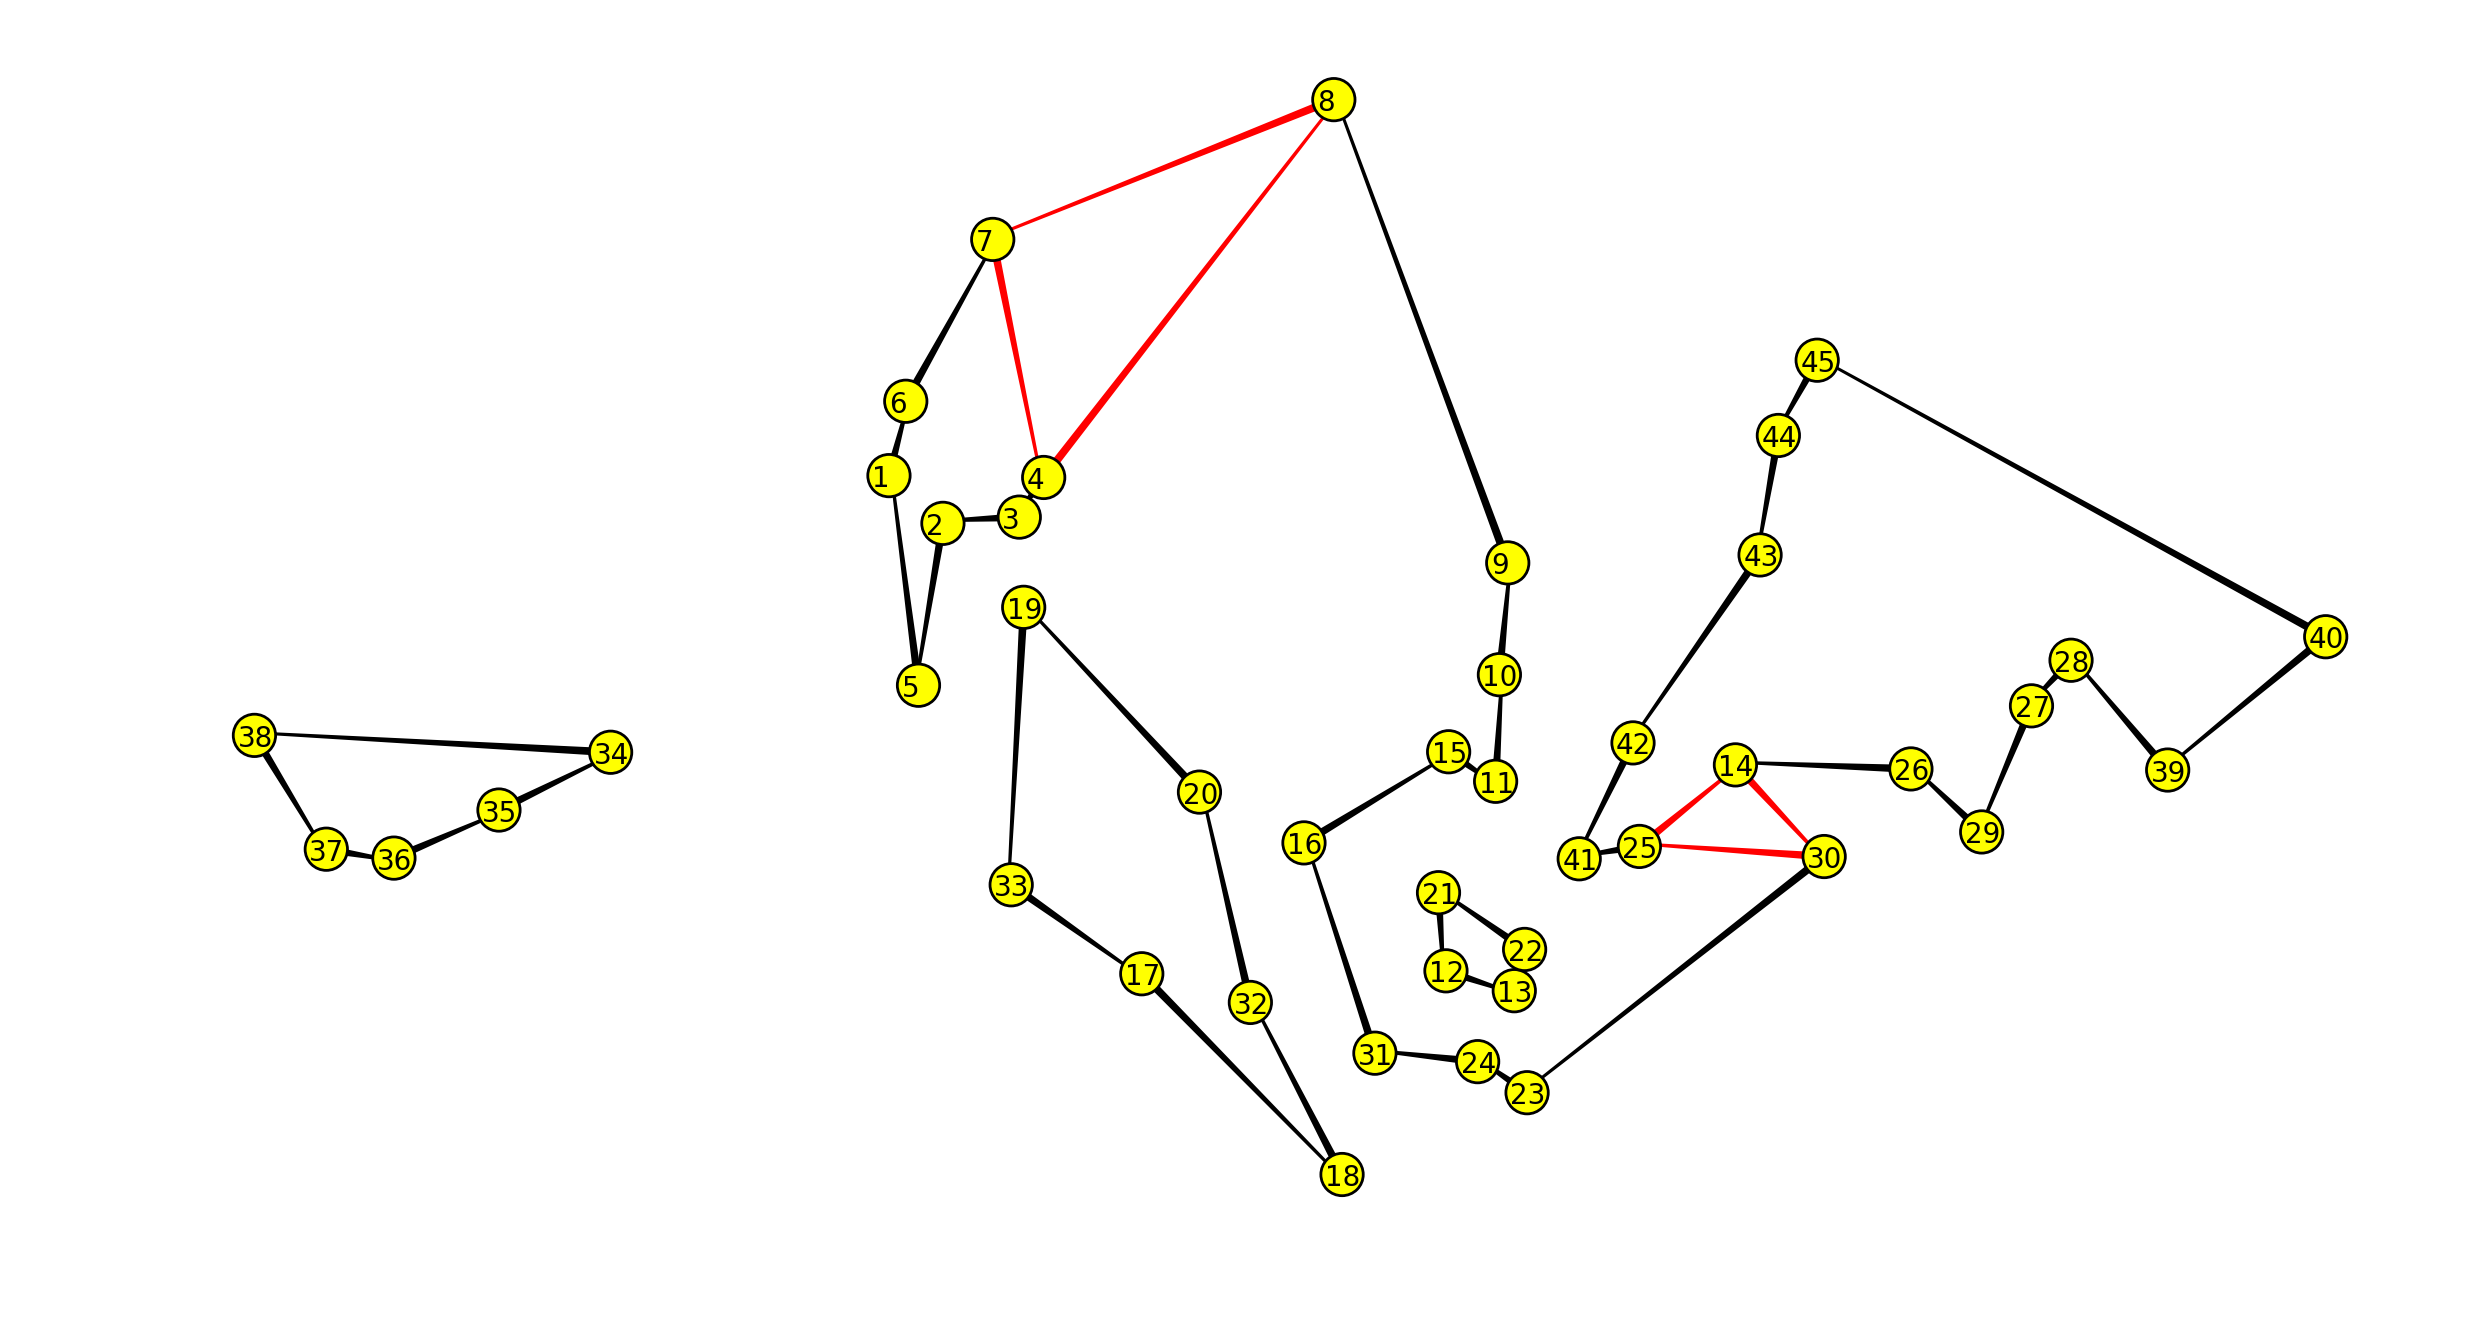

In [13]:
# auxiliary function that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional values, and plotted in red 


E = [
    (7,6),(6,1),(1,5),(5,2),(2,3),(3,4), (8, 9), (9, 10), (10, 11),
    (11, 15), (15, 16), (16, 31), (31, 24), (24, 23), 
    (19, 20), (20, 32), (32, 18), (18, 17), (17, 33), (33, 19), (14,26),
    (21, 22), (22, 13), (13, 12), (12, 21), (23, 30),
    (34, 35), (35, 36), (36, 37), (37, 38), (38, 34),
    (41, 42), (42, 43), (43, 44), (44, 45), (45, 40),
    (26, 29), (29, 27), (27, 28), (28, 39), (39, 40), (41, 25),
]

fE = [
    (4,7),(7,8),(8,4), (14,25), (25,30),(30,14),
]

LL = frac_TSP_plot(E,fE,cities_B1,posn_B1,dist_B1)


length of fractional TSP tour (or TSP_LP solution) : 1434.0


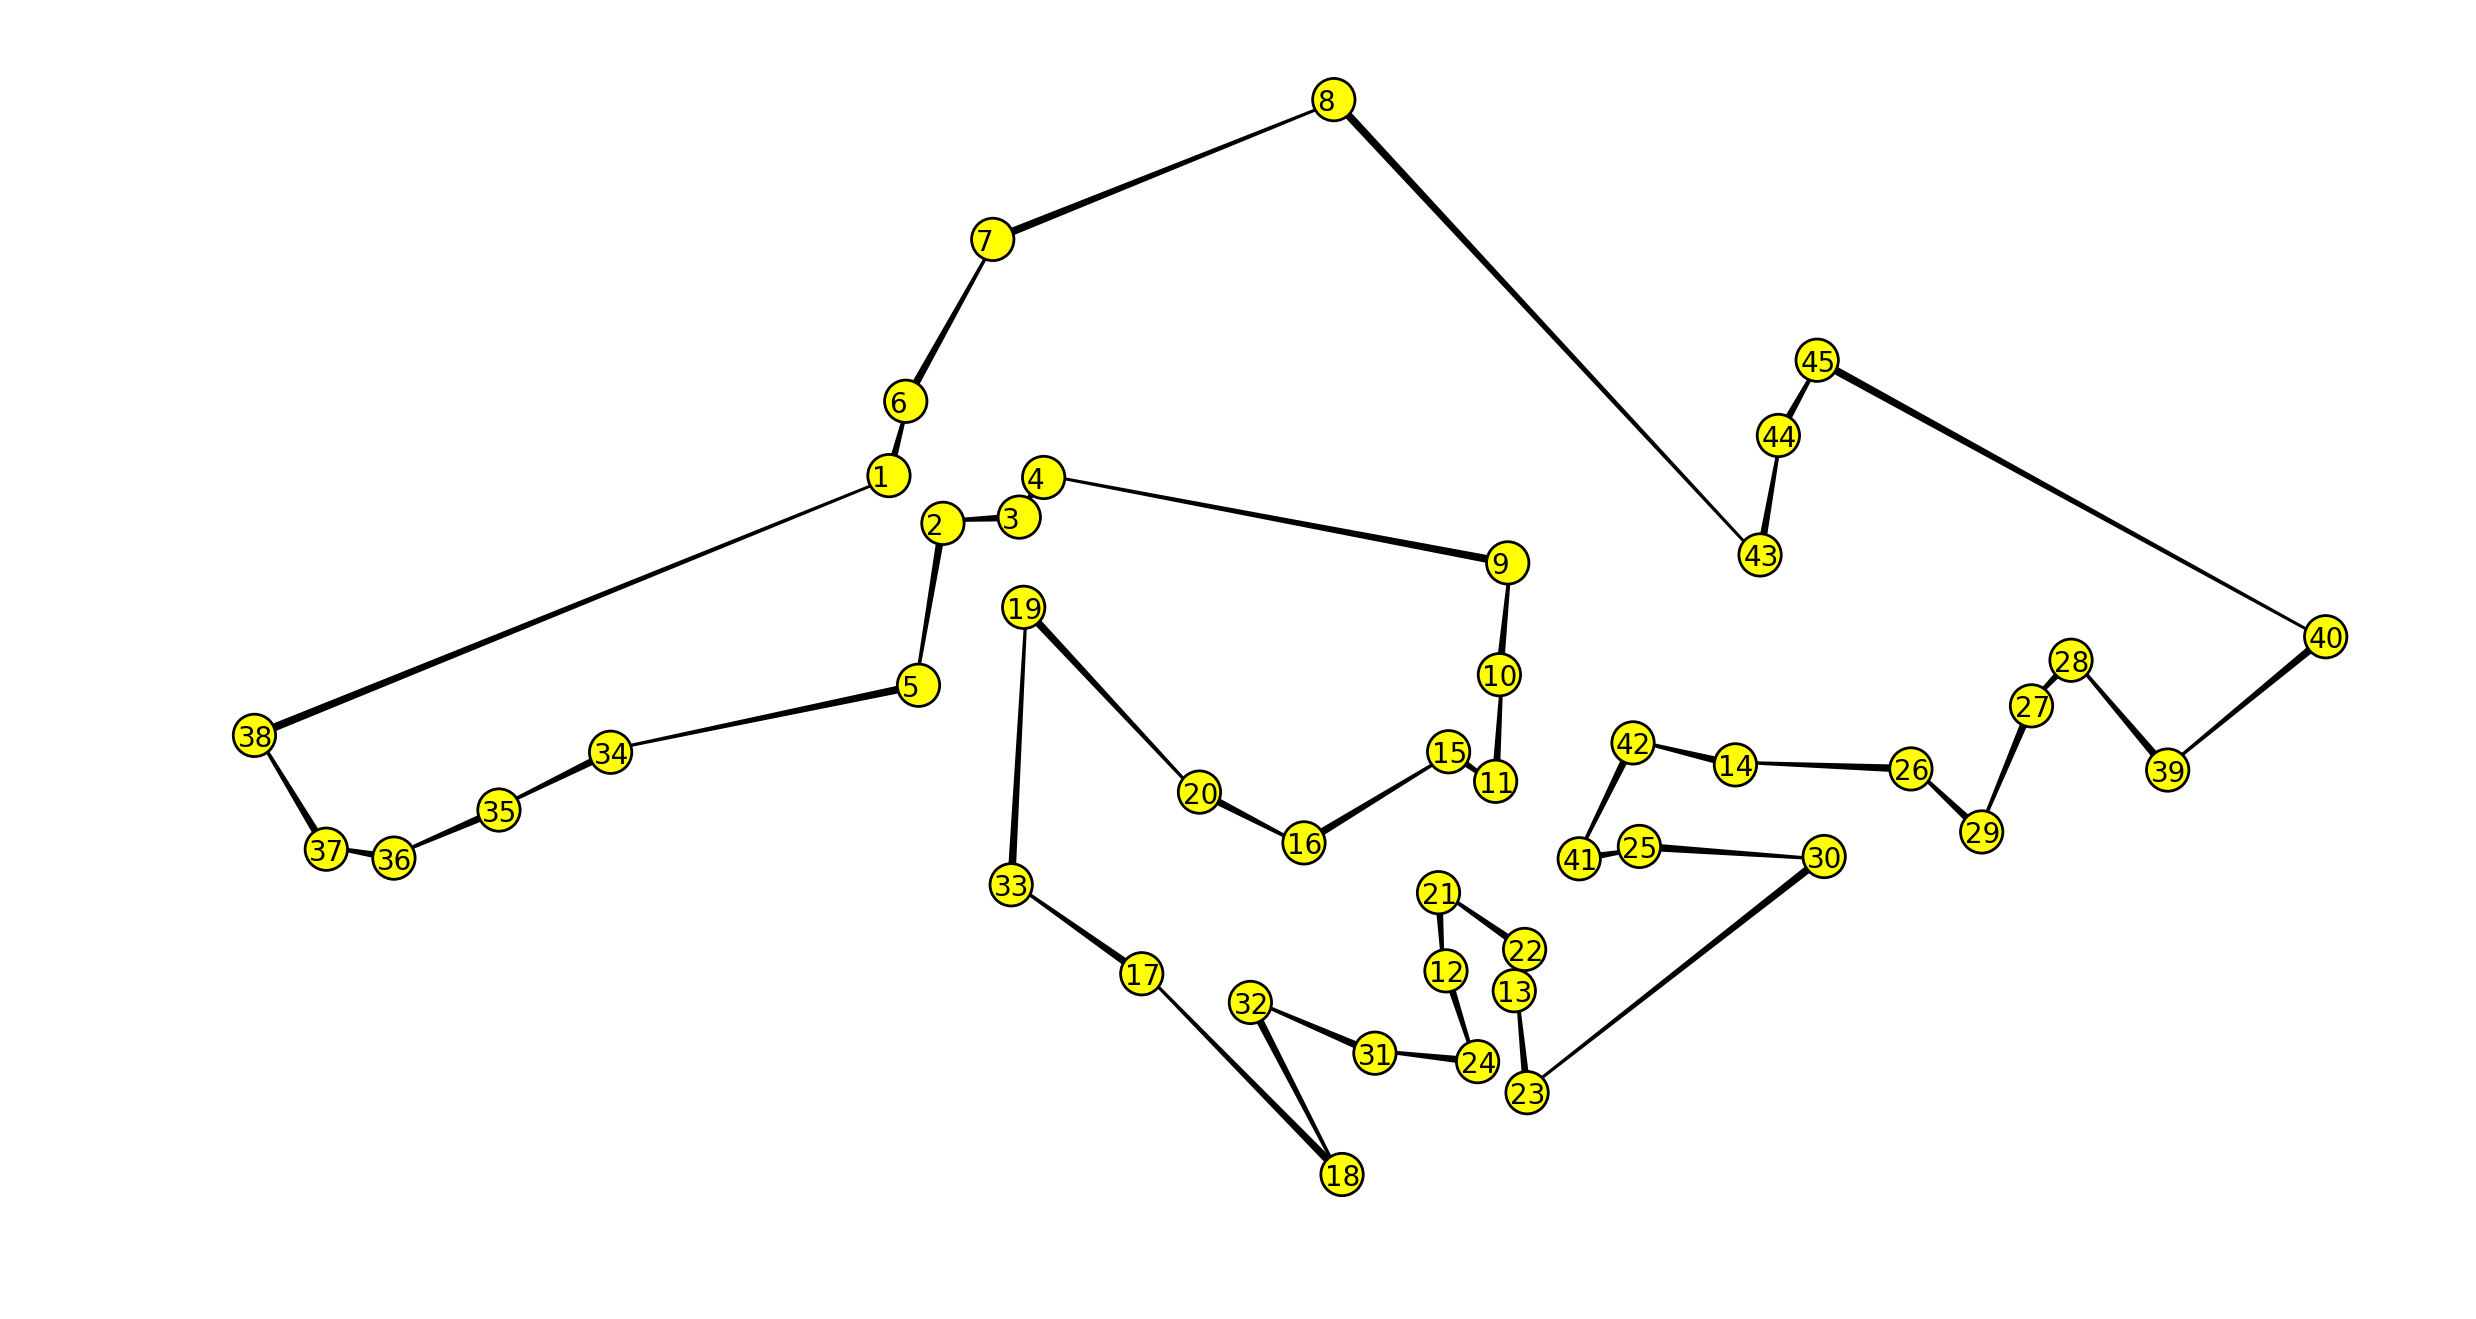

length of candidate TSP tour : 1545


In [11]:
# you can change this tour

candidate_tour2 = [
    8, 7, 6, 1, 
    38, 37, 36, 35, 34, 
    5, 2, 3, 4,  
    9, 10, 11, 15, 16, 
    20, 19, 33, 17, 18, 32,
    31, 24, 12, 21, 22, 13, 23,
    30, 25, 41, 42, 14, 26, 29, 27, 28, 39, 40, 45, 44, 43
]

L2 = TSP_plot(candidate_tour2,cities_B1,posn_B1,dist_B1)

print("length of candidate TSP tour : {}".format(L2))

## TSP B2

In [45]:
# Question B2

from TSP_B2 import *
import pulp

print("number of cities : {}".format(len(cities_B2)))

# you can change this tour

candidate_tour = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
    31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
    41, 42, 43, 44, 45    
]


# auxiliary function that plots out a candidate TSP tour 
#                     and computes its length

L2 = TSP_plot(candidate_tour,cities_B2,posn_B2,dist_B2)

print("length of candidate TSP tour : {}".format(L2))

# auxiliary function that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional, and plotted in red 


E = [
    (1, 43), (2, 3), (3, 4), (4, 5), (5,29), (29, 28), (28, 6), (6,27), (27, 7), (7, 8), (8, 9), (9, 10), 
    (11, 15), (15, 16), (16, 14), (14, 13), (13, 12),
    (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 37),
    (25, 26), (42, 30), (30, 41), (31, 32), (31, 41), 
    (34, 35), (35, 36), (37, 38), (38, 39), (39, 40), 
    (41, 30), (42, 1), (43, 45), (44, 2), (45,44),(40,26),(25,32),
]

fE = [
    (12,17),(17,11),(11,12),  (10,34),(34,36),(36,10)
]

LL = frac_TSP_plot(E,fE,cities_B2,posn_B2,dist_B2)


print("length of fractional TSP tour : {}".format(LL))



# WRITE YOUR CODE HERE

number of cities : 45


NameError: name 'TSP_plot' is not defined

---

## Auxilliary Plotting Functions

In [42]:
# Auxiliary function that
# plots out a candidate TSP tour 
# and computes its length


import matplotlib.pyplot as plt
import math as math
from matplotlib import collections as mc


def TSP_plot(tour,cities,posn,dist):
    fig = plt.figure()
    fig.set_dpi(200)
    fig.set_size_inches(15,30)

    r = 400
    xoffset=-0.8*r
    yoffset=-0.5*r
    displayname = 0

    for city in cities:

        center = posn[city]

        circle = plt.Circle(center, r, ec='black',fc='yellow', zorder = 9)
        plt.text(center[0]+xoffset,center[1]+yoffset,city, zorder=10)
        plt.gca().add_patch(circle)
    
    N = len(cities)
    
    L = 0
    for i in range(N):
        u = tour[i]
        if i<N-1: v = tour[i+1]
        else: v = tour[0]
            
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='k',width=100,head_width=0, zorder=1)
        
        L += dist[(u,v)]
        
    plt.axis('scaled')
    plt.axis('off')
    plt.show()
    
    return L

In [41]:
# Auxiliary functions that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional, and plotted in red 

import matplotlib.pyplot as plt
import math as math
from matplotlib import collections  as mc


def frac_TSP_plot(E,fE,cities,posn,dist):
    fig = plt.figure()
    fig.set_dpi(200)
    fig.set_size_inches(15,30)

    r = 400
    xoffset=-0.8*r
    yoffset=-0.5*r
    displayname = 0

    for city in cities:

        center = posn[city]

        circle = plt.Circle(center, r, ec='black',fc='yellow', zorder = 9)
        plt.text(center[0]+xoffset,center[1]+yoffset,city, zorder=10)
        plt.gca().add_patch(circle)
    
    L = 0
    
    for (u,v) in E:
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='k',width=100,head_width=0, zorder=1)
        
        L += dist[(u,v)]
    
    for (u,v) in fE:
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='red',width=100,head_width=0, zorder=1)
        
        L += 0.5*dist[(u,v)]
    
        
    plt.axis('scaled')
    plt.axis('off')
    plt.show()
    
    return L